In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from psifr import fr
import swarmbar as sb
import warnings

from cymr import cmr
from dcmr import framework
from dcmr import figures
from dcmr import task
from dcmr import decode

# res_dir = Path(os.environ['CDC_RESULTS'])
res_dir = Path('/Users/morton/Dropbox/work/dcmr/cdcatfr2')
# fit_dir = Path(os.environ['CDC_FITS'])
fit_dir = Path('/Users/morton/Dropbox/work/dcmr/cdcatfr2/fits')
# fig_dir = Path(os.environ['CDC_FIGURES'])
fig_dir = Path('/Users/morton/Dropbox/work/dcmr/cdcatfr2/figs/v1') / 'plots'

data_file = res_dir / 'data.csv'
patterns_file = res_dir / 'patterns.hdf5'
model_dir = fit_dir / 'v1'
fig_dir.mkdir(exist_ok=True, parents=True)
figures.set_style()

In [2]:
data = task.read_study_recall(data_file)
data.head()

,subject,list,position,trial_type,item,category,distractor,item_index,block,block_pos,block_len,n_block,curr,prev,base
0,201,1,1,study,MASCARA,obj,0.0,646,1,1,3,6,obj,<NA>,<NA>
1,201,1,2,study,GOLF CLUB,obj,0.0,606,1,2,3,6,obj,<NA>,<NA>
2,201,1,3,study,KEYCHAIN,obj,0.0,626,1,3,3,6,obj,<NA>,<NA>
3,201,1,4,study,LOS ANGELES,loc,0.0,370,2,1,3,6,loc,obj,cel
4,201,1,5,study,GETTYSBURG,loc,0.0,325,2,2,3,6,loc,obj,cel


In [3]:
subj_param = framework.read_fit_param(model_dir / 'fit.csv')
param_def = cmr.read_config(model_dir / 'parameters.json')
patterns = cmr.load_patterns(patterns_file)

In [4]:
subjects = data['subject'].unique()
subj_evidence = []
rng = np.random.default_rng(1)
n_rep = 50
for subject in subjects:
    model = cmr.CMR()
    study = data.query(f'subject == {subject} and trial_type == "study"')
    states = model.record(
        study, 
        {}, 
        subj_param, 
        param_def, 
        patterns, 
        study_keys=['category', 'distractor', 'block_pos'],
    )
    net = states[0]
    l = []
    for i in range(n_rep):
        c = np.vstack([getattr(s, 'c')[net.get_slice('c', 'cat', 'item')] for s in states])
        # c_noise = c + rng.normal(scale=sigma, size=c.shape)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            evidence = decode.classify_patterns(
                study, c, normalization='range', clf='plogreg', C=0.1
            )
        evidence['trial'] = np.arange(evidence.shape[0])
        evidence['rep'] = i
        l.append(evidence)
    evidence = pd.concat(l, axis=0).groupby('trial').mean()
    subj_evidence.append(pd.concat([study.reset_index(), evidence.reset_index()], axis=1).drop(columns='index'))
evidence = pd.concat(subj_evidence, axis=0)

/var/folders/4k/wss4rkc16j70t_mk8f3vf7300000gn/T/ipykernel_21625/1623817457.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  m = evidence.groupby('distractor').apply(decode.evidence_block_pos)
LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


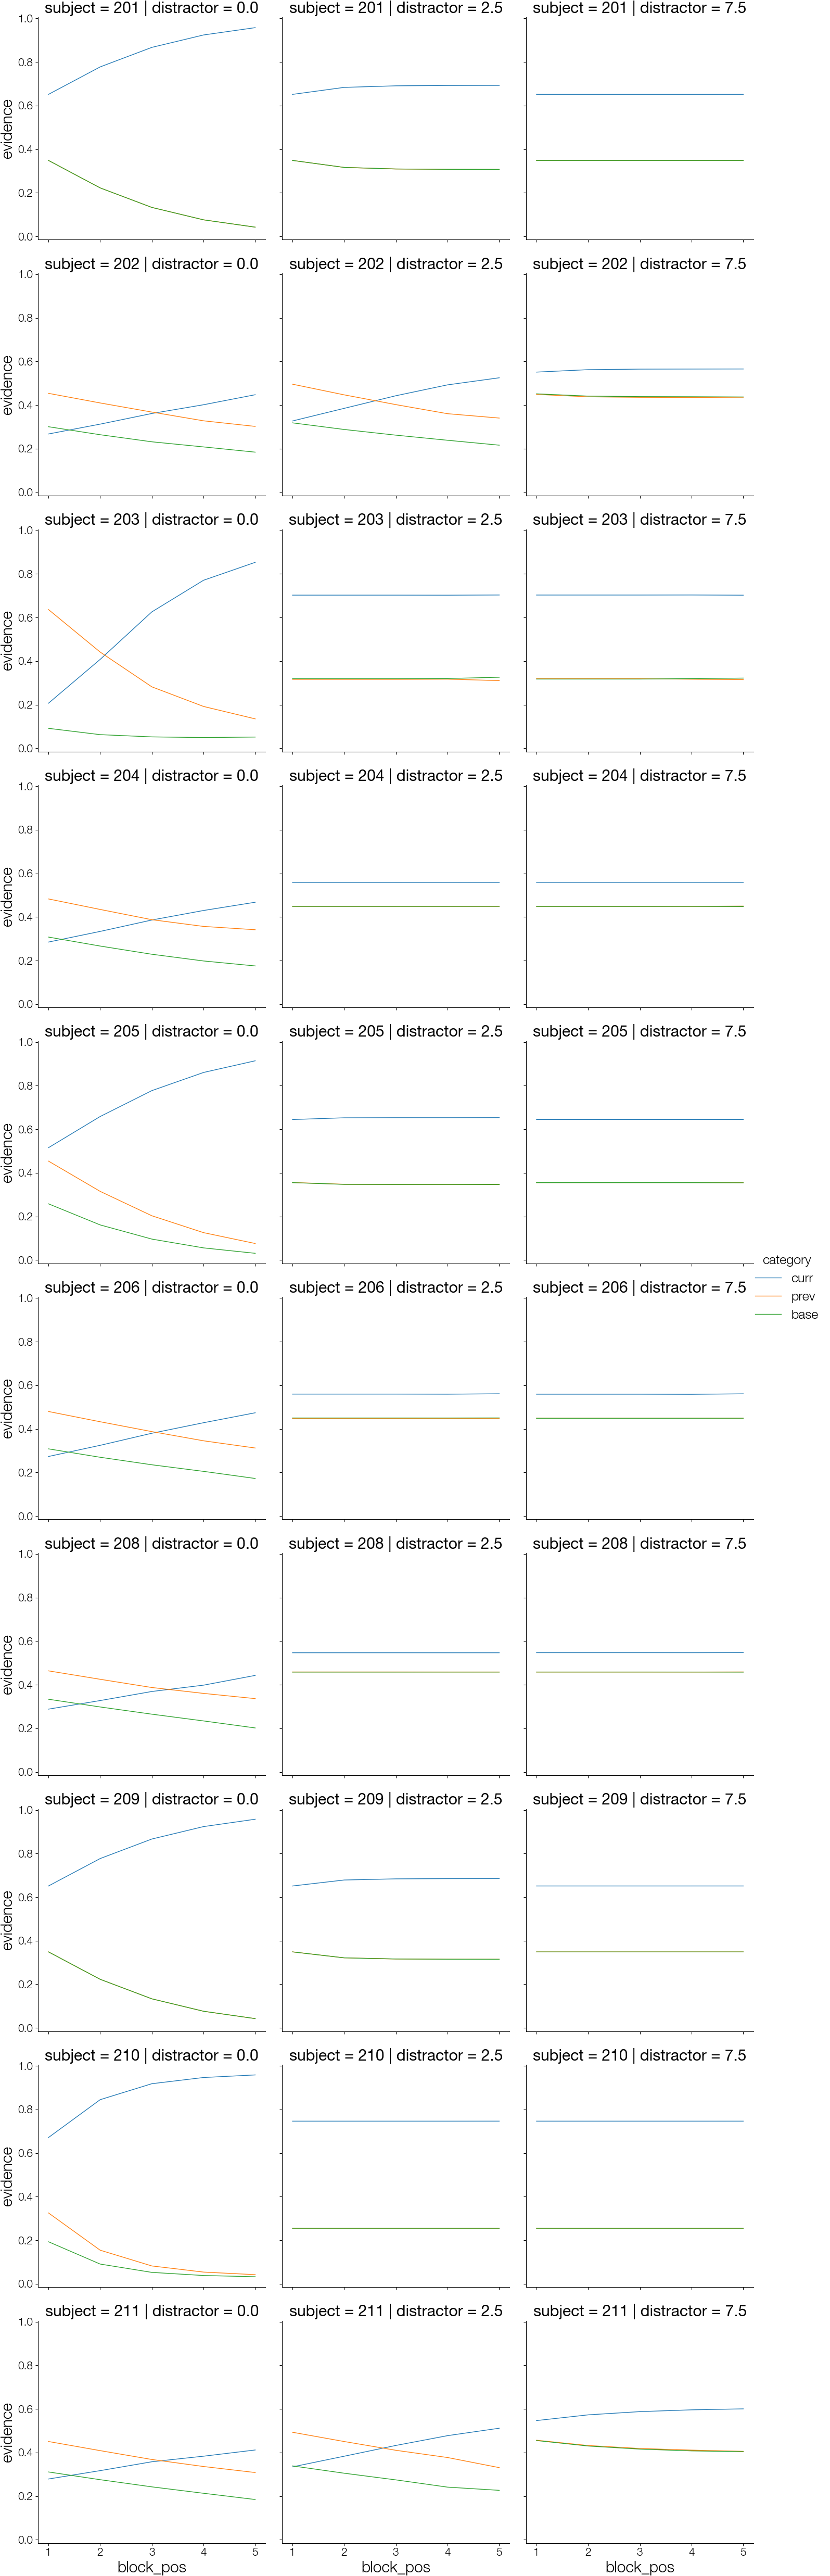

In [5]:
m = evidence.groupby('distractor').apply(decode.evidence_block_pos)
long = pd.melt(
    m.reset_index(), 
    value_vars=['curr', 'prev', 'base'], 
    id_vars=['subject', 'distractor', 'block_pos'],
    var_name='category',
    value_name='evidence',
)
g = sns.relplot(long, x='block_pos', y='evidence', hue='category', row='subject', col='distractor', kind='line')
g.savefig(fig_dir / 'context_evidence_subj.pdf')

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


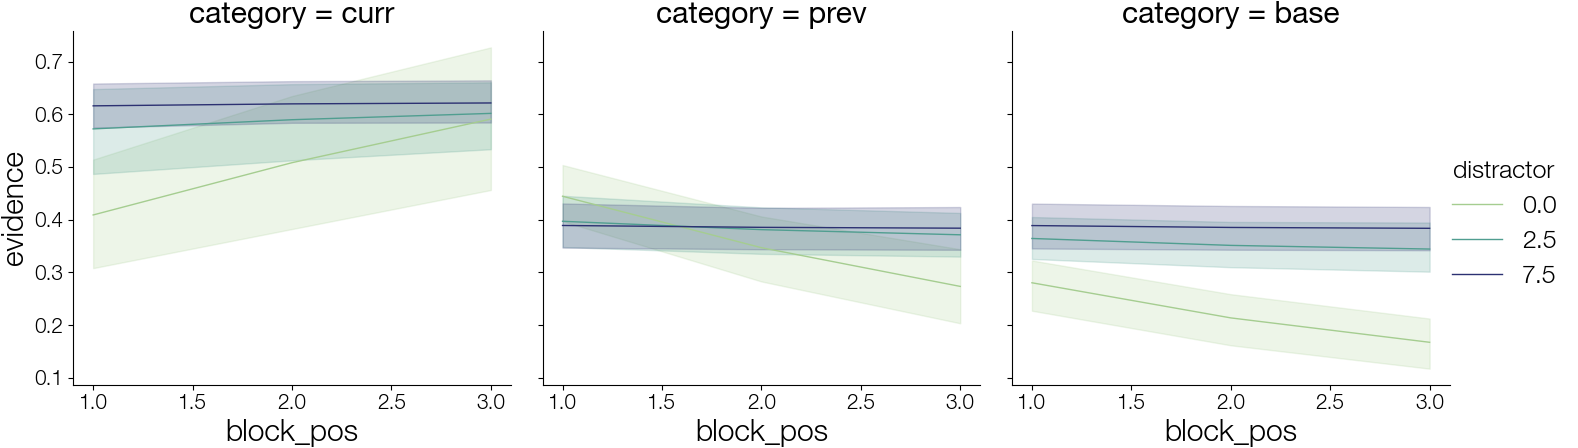

In [6]:
g = sns.relplot(
    long.query('block_pos <= 3'), 
    x='block_pos', 
    y='evidence', 
    hue='distractor', 
    col='category', 
    kind='line',
    palette='crest',
)
g.savefig(fig_dir / 'context_evidence.pdf')

In [7]:
#slope = decode.regress_evidence_block_pos(m)
slope = m.groupby('distractor').apply(decode.regress_evidence_block_pos)
sl = pd.melt(
    slope.reset_index(), 
    value_vars=['curr', 'prev', 'base'], 
    id_vars=['subject', 'distractor'],
    var_name='category',
    value_name='slope',
)
sl.head()

,subject,distractor,category,slope
0,201,0.0,curr,0.107775
1,202,0.0,curr,0.046968
2,203,0.0,curr,0.209532
3,204,0.0,curr,0.050567
4,205,0.0,curr,0.130933


/var/folders/4k/wss4rkc16j70t_mk8f3vf7300000gn/T/ipykernel_21625/423888800.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Current', 'Previous', 'Baseline'])
LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


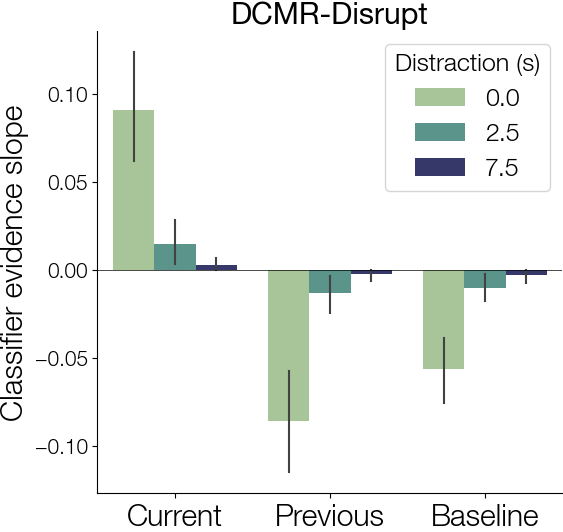

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
sl['Distraction (s)'] = sl['distractor']
sns.barplot(sl, x='category', y='slope', hue='Distraction (s)', palette='crest', ax=ax);
x_lim = ax.get_xlim()
ax.hlines(0, *x_lim, color='k', linewidth=0.5)
ax.set_xlim(x_lim)
ax.set_xlabel('')
ax.tick_params(axis='x', labelsize='large')
ax.set_ylabel('Classifier evidence slope')
ax.set_xticklabels(['Current', 'Previous', 'Baseline'])
ax.set_title('DCMR-Disrupt')
fig.savefig(fig_dir / 'context_evidence_slope.pdf')

/var/folders/4k/wss4rkc16j70t_mk8f3vf7300000gn/T/ipykernel_21625/2748495062.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Current', 'Previous', 'Baseline'])
LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


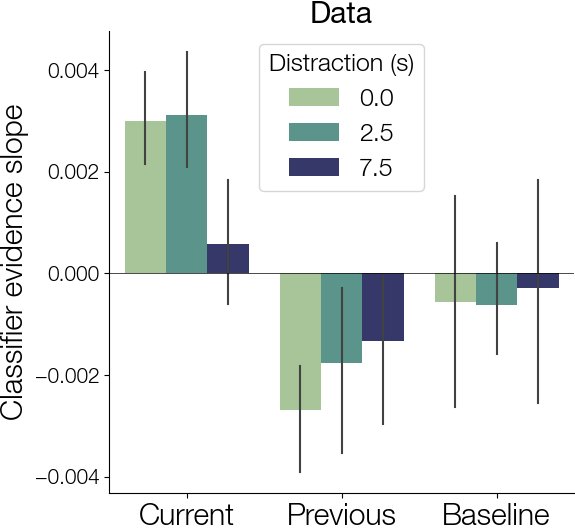

In [9]:
slopes = pd.read_csv(res_dir / 'slopes.csv')
slopes['subject'] = np.repeat(data['subject'].unique(), 9)
slopes['Distraction (s)'] = slopes['condition'].replace({'ifr': "0", 'cd1': "2.5", 'cd2': "7.5"}).astype(float)

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(slopes, x='category', y='slope', hue='Distraction (s)', palette='crest', ax=ax);
x_lim = ax.get_xlim()
ax.hlines(0, *x_lim, color='k', linewidth=0.5)
ax.set_xlim(x_lim)
ax.set_xlabel('')
ax.tick_params(axis='x', labelsize='large')
ax.set_ylabel('Classifier evidence slope')
ax.set_xticklabels(['Current', 'Previous', 'Baseline'])
ax.set_title('Data')
fig.savefig(fig_dir / 'eeg_evidence_slope.pdf')